# 쇼핑몰 지점별 매출액 분석 시각화

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## feature 설명

- train.csv : 학습 데이터
- id : 샘플 아이디
- Store : 쇼핑몰 지점
- Date : 주 단위(Weekly) 날짜
- Temperature : 해당 쇼핑몰 주변 기온
- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
- Unemployment : 해당 쇼핑몰 지역의 실업률
- IsHoliday : 해당 기간의 공휴일 포함 여부
- Weekly_Sales : 주간 매출액 (목표 예측값)


본 대회에서는 베이스라인처럼 train 데이터만 쓰겠습니다

## 데이터 확인 및 전처리

In [ ]:
# 필요한 패키지 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import datetime as dt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/데이콘/쇼핑몰 지점별 매출액 분석시각화 경진대회/train.csv')

### 데이터의 전체적인 정보 확인

In [ ]:
data.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [ ]:
# data의 shape
data.shape

(6255, 13)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [ ]:
# 결측값 개수
data.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [ ]:
data.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


우선 데이터를 보고 해야할것은
1. Date 날짜형식으로 바꿔주기
2. Temperature를 섭씨기준으로 바꿔주기
3. IsHoliday(해당 기간의 공휴일 포함 여부)를 보기좋게 (0:'False',1:'True')로 바꿔주기
4. Promotion1	~	Promotion5의 결측값 처리
5. Promotion2, Promotion3에 음수에 있는 값을 0으로 처리해야한다


####1. Date를 날짜형식으로 바꿔주고 연, 월, 일, 요일을 분리해보자

In [ ]:
data.Date = pd.to_datetime(data.Date, dayfirst=True)

In [ ]:
# 연
data['year'] = data['Date'].apply(lambda x:x.year)
data['month'] = data['Date'].apply(lambda x:x.month)
# 일
data['day'] = data['Date'].apply(lambda x:x.day)
# 요일 (0:월 ~ 6:일)
data['Day_of_the_week']=data['Date'].dt.dayofweek

In [ ]:
print('데이터 수집기간 :',data['Date'].min(),'~',data['Date'].max())

데이터 수집기간 : 2010-02-05 00:00:00 ~ 2012-09-28 00:00:00


#### 2. Temperature를 섭씨기준으로 바꿔주자

In [ ]:
def F2C(Fahrenheit):
    Celsius = (Fahrenheit - 32) * 5 / 9
    return Celsius


data.Temperature = data.Temperature.apply(F2C)

#### 3. IsHoliday(해당 기간의 공휴일 포함 여부)를 보기좋게 (0:'False',1:'True')로 바꿔주기

In [ ]:
data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 0 if x==False else 1)

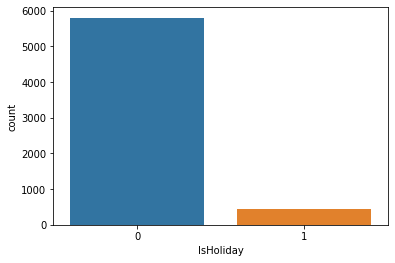

In [ ]:
g = sns.countplot(data["IsHoliday"])

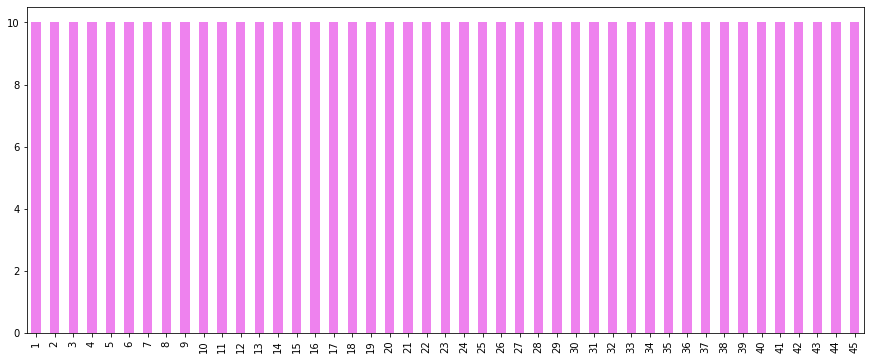

In [ ]:
fig = plt.figure(figsize = (15,6))
data[data["IsHoliday"]==1]['Store'].value_counts().sort_index().plot.bar(color='violet')

plt.xticks(rotation=90)
plt.show()

각 store별 공휴일 포함여부는 10개로 동일하다

In [ ]:
data[data["IsHoliday"]==1]['month'].unique()

array([ 2,  9, 11, 12])

또한 베이스라인에서는 만약 동일한 날짜에 다른 IsHoliday 값을 갖는다면 각 지점이 서로 다른 나라(행정 구역)에 속할 가능성이 있다고 했다. 모든 Store가 주기적으로 2월, 9월, 11월, 12월에 공휴일이 하나씩, 즉 데이터수집기간의 공휴일은 각 10개씩 있으므로 같은 행정구역에 속한다고 할 수 있다.

#### 4. Promotion1	~	Promotion5의 결측값 처리

근데 우선 Promotion2와 Promotion3에 0이하인 이상치가 있다. 이를한번 확인해보자


In [ ]:
data[(data['Promotion2']<0)|(data['Promotion3']<0)].head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,Day_of_the_week
528,529,4,2012-03-23,15.038889,3.759,8806.80,-10.50,5.99,739.14,4396.97,4.607,0,2091592.54,2012,3,23,4
688,689,5,2012-08-17,30.844444,3.571,1649.56,-10.98,2.31,1955.75,1205.23,5.603,0,314014.18,2012,8,17,4
1243,1244,9,2012-08-10,31.477778,3.494,3180.78,-9.94,1.40,2112.03,2314.58,5.277,0,538713.47,2012,8,10,4
1247,1248,9,2012-09-07,31.072222,3.730,4837.99,-5.96,22.74,602.80,1377.59,5.277,1,565812.29,2012,9,7,4
1361,1362,10,2012-03-16,16.727778,4.273,3977.45,-10.50,6.03,1928.50,2273.92,7.545,0,1930814.66,2012,3,16,4


따라서 Promotion2와 Promotion3가 음수값이 있어서 이를 이상치로 간주하고 0으로 바꿔주도록 하자

In [ ]:
data['Promotion2'] = data['Promotion2'].apply(lambda x: 0 if x < 0 else x)
data['Promotion3'] = data['Promotion3'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
data[(data['Promotion2']<0)|(data['Promotion3']<0)].head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,Day_of_the_week


그리고 일단 Promotion1 에서 언제부터 NA가 아닌 값이 등장했는지 확인해보자

In [ ]:
feature = ['Promotion1','Promotion2',	'Promotion3',	'Promotion4',	'Promotion5']
for i in range(len(feature)):
  print(data[data[feature[i]].isnull() == False]['Date'].iloc[0])

2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00


2011-11-11부터 처음으로 결측값이 아닌 값이 등장했다. 그렇다면 2011-11-11부터 프로모션에 결측값이 있으면 해당 프로모션이 진행되지 않았다고 하고 0으로 채우고 그 이전은 프로모션이 아예 진행되지 않았다고 가정하고 0으로 채운다. 그 후에 히트맵을 다시 보도록 하자

In [ ]:
data = data.fillna(0)

- 2011-11-11부터의 히트맵

In [ ]:
data_date_111111 = data[data['Date']>='2011-11-11']

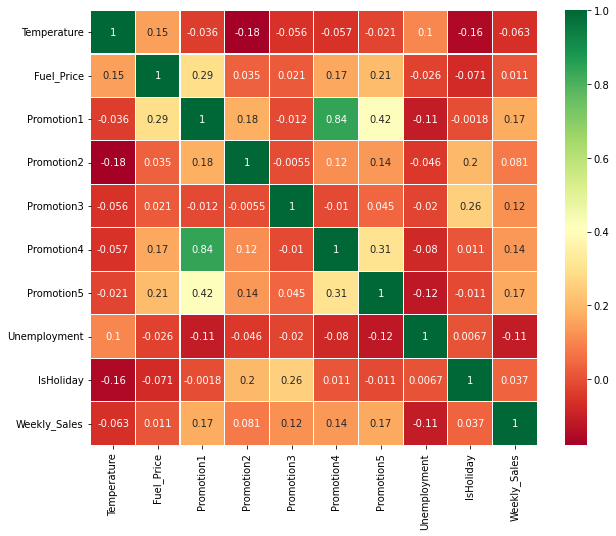

In [ ]:
data_date_111111_columns = data[['Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales']]
sns.heatmap(data_date_111111_columns.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

# 현재 figure를 확인
fig=plt.gcf()

# 크기 지정
fig.set_size_inches(10,8)
plt.show()

Promotion1과 Promotion4의 상관관계가 매우 높다는 것을 알 수 있다. 또한 Promotion3과 IsHoliday의 상관관계도 조금 있는 편이다.

- 프로모션 결측값 0으로 대체후 모든 기간의 히트맵

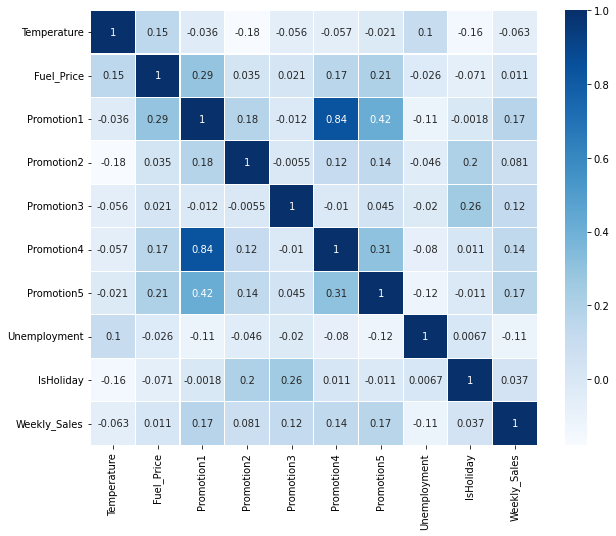

In [ ]:
data_columns = data[['Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales']]
sns.heatmap(data_columns.corr(),annot=True,cmap='Blues',linewidths=0.2)

# 현재 figure를 확인
fig=plt.gcf()

# 크기 지정
fig.set_size_inches(10,8)
plt.show()

Promotion1과 Promotion4의 상관관계가 아까보다 높아졌다는 것을 알 수 있다. Weekly_Sales 기준으로 히트맵을 다시 그려보자

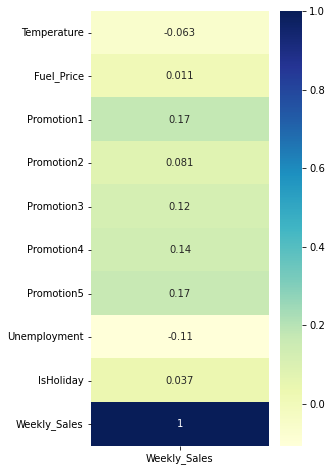

In [ ]:
fig = plt.figure(figsize = (4,8))
data_columns = data[['Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales']]

sns.heatmap(data_columns.corr()[['Weekly_Sales']],annot=True, cmap="YlGnBu")

전반적으로 프로모션들이 Weekly_Sales과 상관성이 높다는 것을 알 수 있다.

기본적인 데이터처리는 끝났으니 feature별로 여러가지를 살펴보자

- 요일

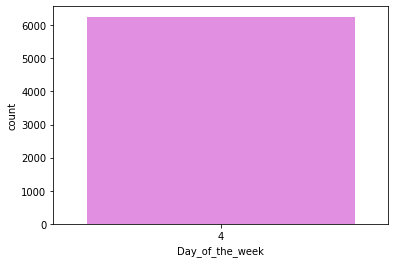

In [ ]:
sns.countplot(data['Day_of_the_week'],color='violet')

데이터는 모두 금요일에 수집되었다 ! 그래서 Day_of_the_week은 drop하도록 하자

In [ ]:
data = data.drop('Day_of_the_week',axis=1)

- 실업률

In [ ]:
data_group_unemployment = data.groupby(['Date'])[['Unemployment']].mean()

In [ ]:
data_group_unemployment

,Unemployment
Date,
2010-02-05,8.619311
2010-02-12,8.619311
2010-02-19,8.619311
2010-02-26,8.619311
2010-03-05,8.619311
...,...
2012-08-31,7.237333
2012-09-07,7.237333
2012-09-14,7.237333


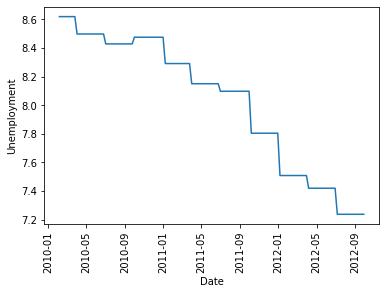

In [ ]:
sns.lineplot(x=data_group_unemployment.index,y=data_group_unemployment['Unemployment'],data=data_group_unemployment,legend=False)
plt.xticks(rotation=90)
plt.show()

그래프가 계단형식인것을 봐서 실업률은 분기별로 계산하는 것으로 추측할 수 있다 ! 또한 시간에 따라 실업률은 감소추세란 것을 알 수 있다.

- 주간 판매량 그래프

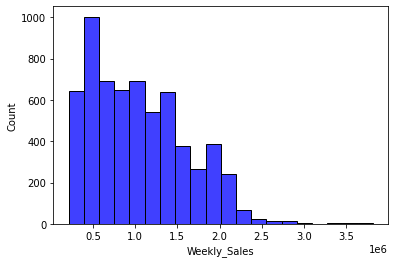

In [ ]:
sns.histplot(x= 'Weekly_Sales', data=data, bins=20, color='blue')

아니 대체 주간 판매량이 3백만이 넘는건 뭐야? 

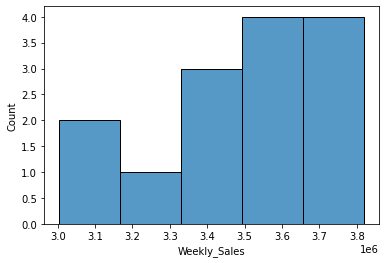

In [ ]:
sns.histplot(x=data[data['Weekly_Sales'] > 3000000]['Weekly_Sales'],data=data)

In [ ]:
data[data['Weekly_Sales'] > 3000000][['Date','Weekly_Sales']]

,Date,Weekly_Sales
185,2010-12-24,3436007.68
237,2011-12-23,3224369.80
463,2010-12-24,3526713.39
511,2011-11-25,3004702.33
515,2011-12-23,3676388.98
1297,2010-12-24,3749057.69
1349,2011-12-23,3487986.89
1714,2010-12-24,3595903.20
1766,2011-12-23,3556766.03
1853,2010-12-24,3818686.45


크리스마스가 있는주에 매출액이 상당하다는 것을 알 수 있다. 그리고 11월 넷째주는 미국의 추수감사절이라고 한다 !

- 시간에 따른 프로모션 변화

프로모션 변화를 자세히 보기 위해 프로모션이 진행된 후 2011-11-11부터의 프로모션 정보만 보자

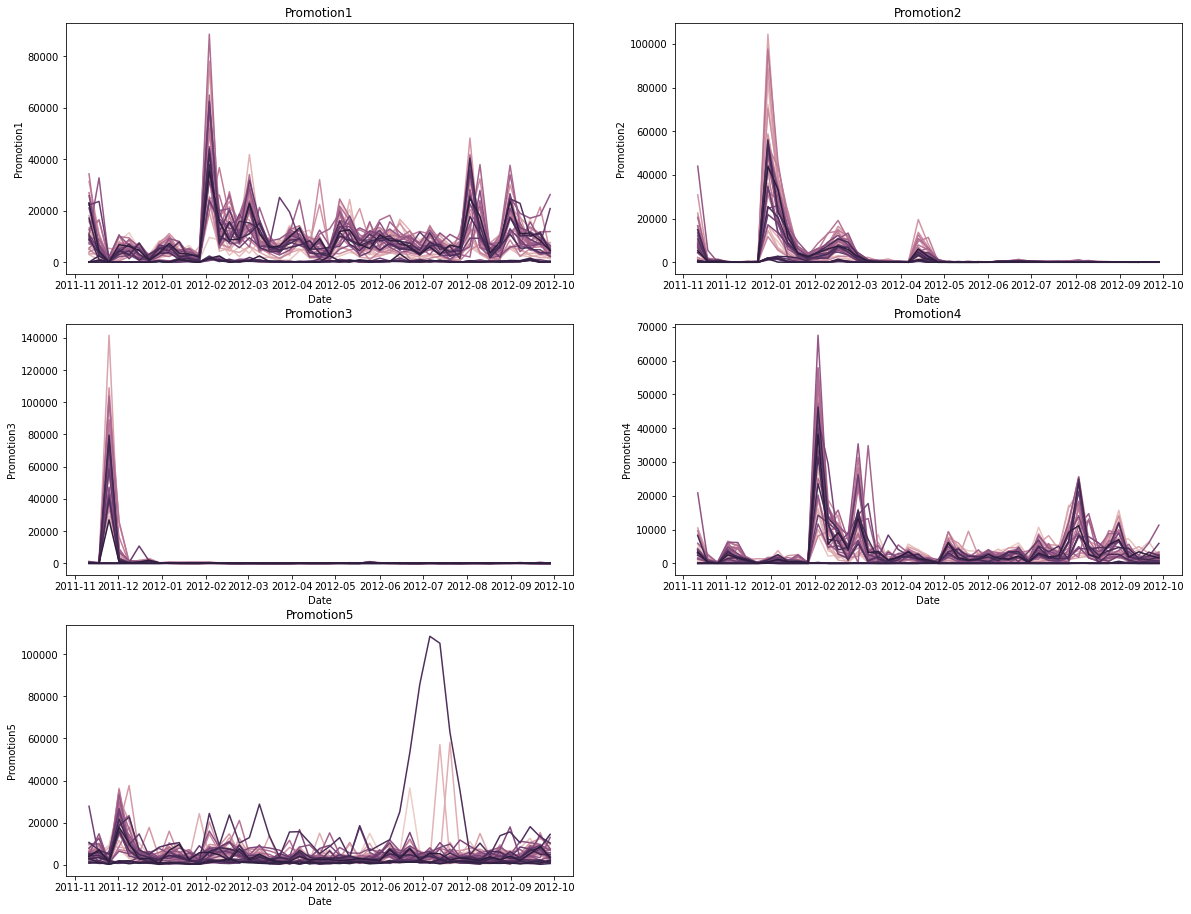

In [ ]:
feature = ['Promotion1','Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(11,2,i+1)
    plt.title(feature[i])
    sns.lineplot(x='Date',y=feature[i],hue='Store',data=data_date_111111,legend=False)
plt.show()

프로모션은 시간에 따라 스토어별로 비슷한 추세를 갖는다고 할 수 있다.

---

## 가설에 따른 시각화결과 및 결론

### 1. 연도별, 월별, 일별로 주간 매출액에 차이가 있을까 ?

- 전체 연도별 매출 평균

In [ ]:
data_group_year_ = data[["year","Weekly_Sales"]].groupby('year').mean()

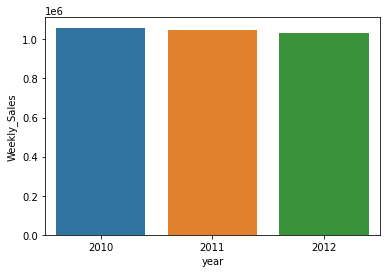

In [ ]:
sns.barplot(x=data_group_year_.index, y = data_group_year_['Weekly_Sales'])
plt.show()

사실 2011년 데이터가 많기 때문에 sum이 아닌 mean으로 봤고 2010년에 주간 매출 평균이 가장 높지만 큰 차이는 나지 않는다.

- 월별 매출 평균(2011)<br>
2011년만 1월부터 12월까지의 데이터가 모두 담겨있어서 2011년 데이터만 보도록 하자

In [ ]:
data_group_month_2011 = data[["month","Weekly_Sales"]].groupby('month').mean()

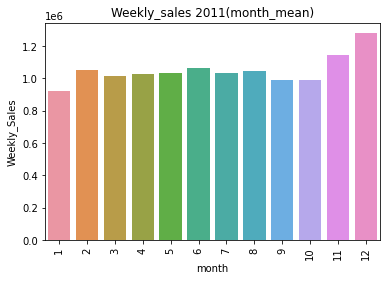

In [ ]:
sns.barplot(x=data_group_month_2011.index, y = data_group_month_2011['Weekly_Sales'], data=data)
plt.title('Weekly_sales 2011(month_mean)')
plt.xticks(rotation=90)
plt.show()

역시 12월 ! 연말과 크리스마스가 있어서 그런지 주간 매출액이 높다. 11월도 추수감사절이 있어서 주간 매출액이 높다고 추측할 수 있다.

- 일별 매출 평균(2011)

In [ ]:
data_group_month_2011_day = data[["day","Weekly_Sales"]].groupby('day').mean()

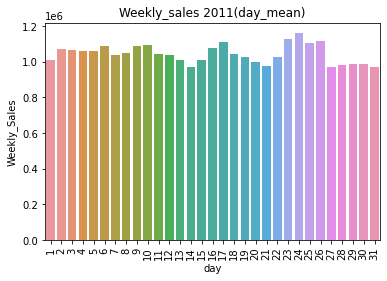

In [ ]:
sns.barplot(x=data_group_month_2011_day.index, y = data_group_month_2011_day['Weekly_Sales'], data=data)
plt.title('Weekly_sales 2011(day_mean)')
plt.xticks(rotation=90)
plt.show()

23일 ~ 26일에 기록한 주간 매출액이 가장 높기는 하나 크리스마스와 추수감사절이 달의 마지막주에 포함되서가 아닌가 추측해본다.

### 2. 각 store별 총 기간에 따른 매출액 변화

<Figure size 1440x5760 with 0 Axes>

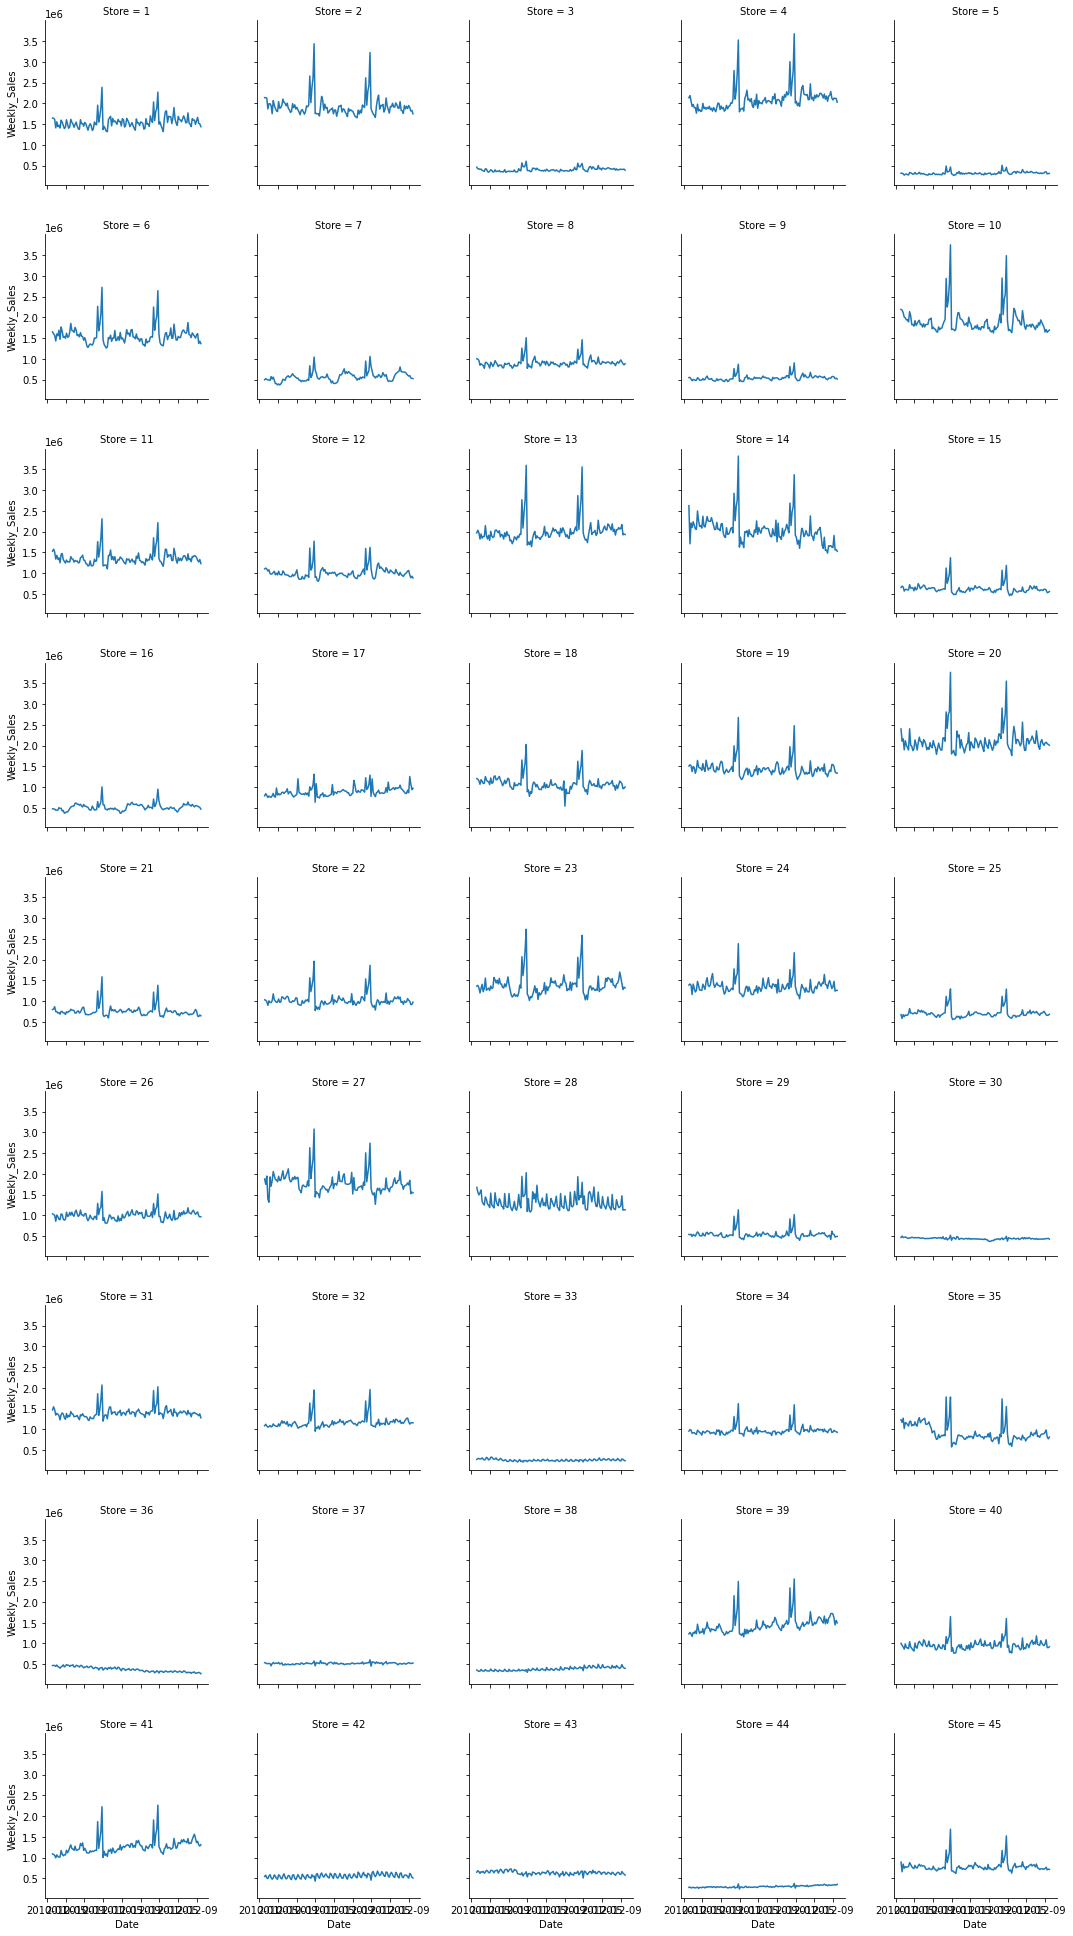

In [ ]:
plt.figure(figsize=(20,80))

g = sns.FacetGrid(data, col='Store',col_wrap=5)
g = g.map(plt.plot, 'Date','Weekly_Sales')
g = g.fig.subplots_adjust(wspace=0.3, hspace=0.3)

스토어별로 시간별 주간매출액 변화폭이 다르다는 것을 알 수 있다.

### 3. 기온이 너무 높거나 낮으면 사람들이 안나와서 매출액이 줄까 ?

- 기온과 주간 매출액의 상관성

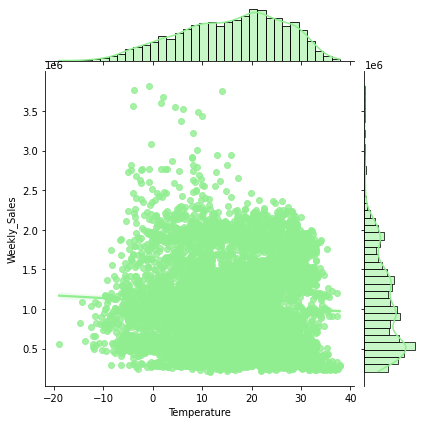

In [ ]:
sns.jointplot(x=data['Temperature'],y=data['Weekly_Sales'],kind='reg',data=data,color='lightgreen')

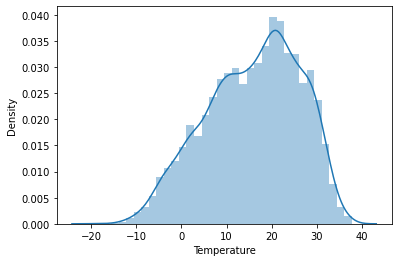

In [ ]:
sns.distplot(data['Temperature'])

위 jointplot을 보면 별다른 온도와 주간 매출액의 특별한 상관관계를 볼 수 없다.

### 4. 어느 쇼핑몰이 가장 매출액이 높을까?

- 스토어별 주간 매출액합 비교

In [ ]:
data_max_store_sum = data.groupby('Store')[['Weekly_Sales']].sum()

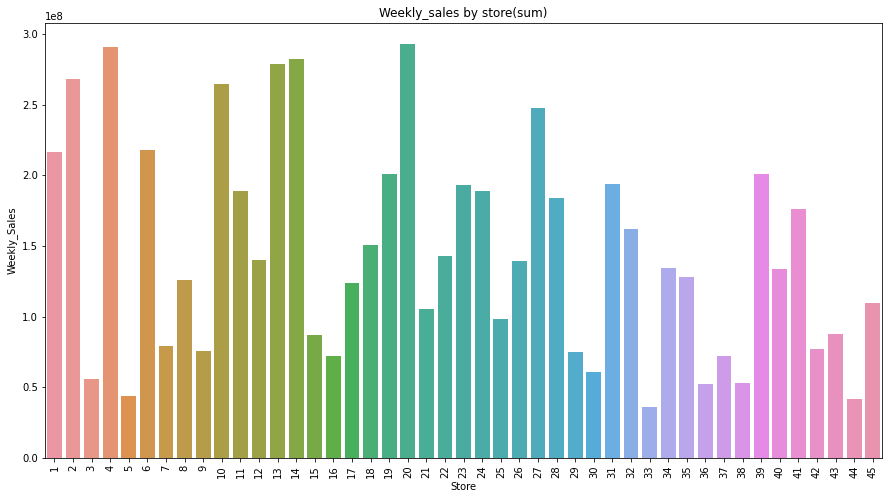

In [ ]:
fig = plt.figure(figsize = (15,8))
sns.barplot(x=data_max_store_sum.index, y=data_max_store_sum['Weekly_Sales'], data=data )
plt.title('Weekly_sales by store(sum)')
plt.xticks(rotation=90)
plt.show()

Store 4와 20이 판매량 합이 가장 높다

- 스토어별 매출액 평균비교

In [ ]:
data_max_store_mean = data.groupby('Store')[['Weekly_Sales']].mean().sort_values(by='Weekly_Sales')

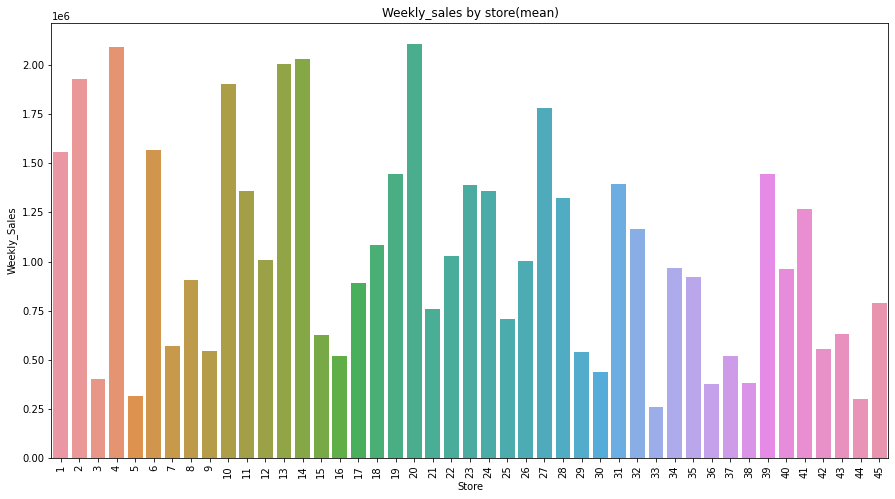

In [ ]:
fig = plt.figure(figsize = (15,8))
sns.barplot(x=data_max_store_mean.index, y=data_max_store_mean['Weekly_Sales'], data=data)
plt.title('Weekly_sales by store(mean)')
plt.xticks(rotation=90)
plt.show()

Store 20이 주간 매출액 평균이 가장 높다

### 5. 만약 해당주변지역의 연료가 싸면 매출액이 늘까? 아니면 관계가 없을까 ?

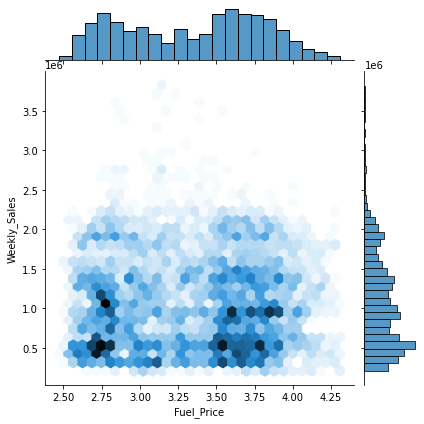

In [ ]:
sns.jointplot(x=data['Fuel_Price'],y=data['Weekly_Sales'],kind='hex',data=data)

사실은 이 경우도 주간 매출액과 해당쇼핑몰 주변 연료가격은 별 관계가 없다는 것을 알 수 있다.

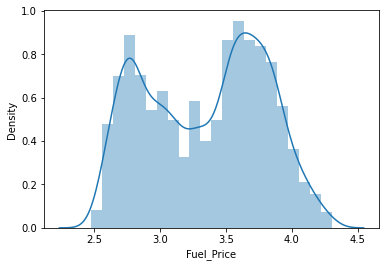

In [ ]:
sns.distplot(data['Fuel_Price'])

그도 그럴것이 연료가격의 distplot을 그려보면 약 2.7과 3.7 근방의 가격이 많으므로 jointplot의 결과가 위와 같을 수 있다고 본다.



### 6. 프로모션값이 높으면 주간매출액도 높을까?

프로모션에 대한 정확한 정보를 위해 프로모션이 진행된 후 2011-11-11부터의 프로모션 정보만 보자

편리한 추측을 위해 프로모션값을 모두 더한 파생변수를 만든다.

In [ ]:
data_date_111111 ['Promotion_sum'] = data_date_111111 ['Promotion1']+data_date_111111 ['Promotion2']+data_date_111111 ['Promotion3']+data_date_111111 ['Promotion4']+data_date_111111 ['Promotion5']

스토어별 프로모션합과 주간매출액의 합

In [ ]:
data_promotion = data_date_111111.groupby(['Store'])[['Promotion_sum','Weekly_Sales']].sum()

In [ ]:
data_promotion.head()

,Promotion_sum,Weekly_Sales
Store,,
1,1012139.16,7.615681e+07
2,1382360.03,9.212970e+07
3,339401.48,2.011747e+07
4,1323483.96,1.047780e+08
5,398882.39,1.592666e+07


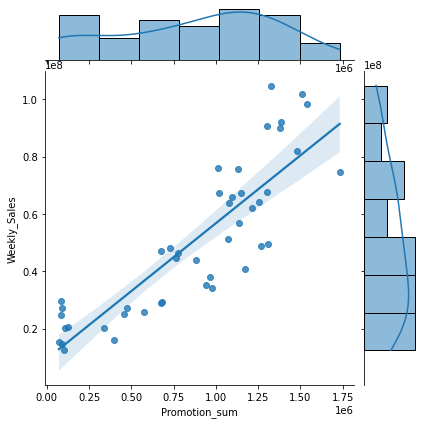

In [ ]:
sns.jointplot(x='Promotion_sum',y='Weekly_Sales',kind='reg',data=data_promotion)

역시 프로모션의 효과는 굉장했다 !

data_promotion을 데이터프레임 형식으로 변경하고 스토어별 프로모션합과 주간매출액 비교해보자

In [ ]:
data_promotion = data_promotion.reset_index()

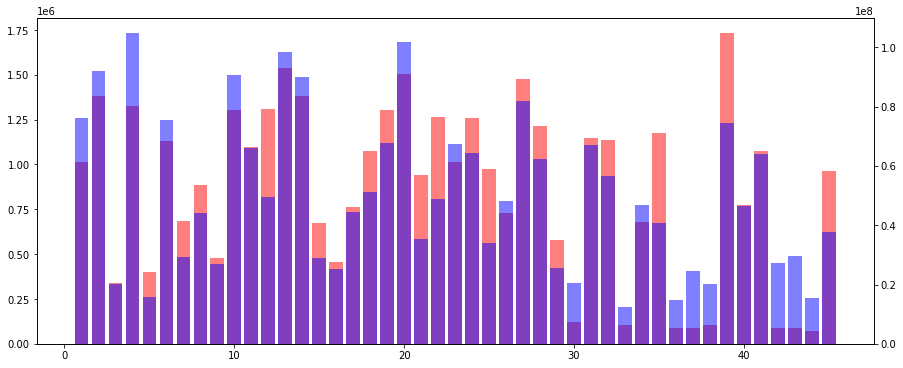

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.bar(data_promotion['Store'], data_promotion['Promotion_sum'], color = 'red', alpha = 0.5)

# twinx로 x축 공유
ax2 = ax1.twinx()
ax2.bar(data_promotion['Store'], data_promotion['Weekly_Sales'], color = 'blue', alpha = 0.5)
plt.show()

좌측 y축은 프로모션합, 우측 y축은 주간 매출액의 합계다. 따라서 프로모션값이 높을수록 매출액이 높다는 것을 알 수 있다.